<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week3/CNN_%26_MLP_Tensorflow_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN & MLP menggunakan TensorFlow🍿**

CNN dirancang khusus untuk menangani data berbentuk grid, seperti gambar.MLP menggunakan fungsi aktivasi seperti ReLU atau sigmoid untuk menangani non-linearitas.Cocok untuk data terstruktur seperti tabel dalam tugas regresi dan klasifikasi.

MLP : Setiap neuron di satu lapisan terhubung penuh ke semua neuron di lapisan berikutnya (Fully Connected Layer).

CNN : Menggunakan lapisan konvolusi untuk mengekstrak fitur dari gambar dengan filter (kernel).Memiliki pooling layer (misalnya MaxPooling) untuk mengurangi dimensi fitur dan mengurangi overfitting.







## Persiapan dan Instalasi🥨

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

In [ ]:
# Gunakan GPU jika tersedia
device_name = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device_name}")


Using device: GPU


## Load Data📊

In [ ]:
# Load dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [ ]:
# Normalisasi data ke range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0



In [ ]:
y_train, y_test = keras.utils.to_categorical(y_train, 10), keras.utils.to_categorical(y_test, 10)


In [ ]:
# **Flatten label sebelum one-hot encoding (agar tetap 50000, bukan 500000)**

#if y_train.shape[-1] == 1:
#    y_train = keras.utils.to_categorical(y_train.flatten(), 10)
#    y_test = keras.utils.to_categorical(y_test.flatten(), 10)



In [ ]:
# Cek ukuran data untuk memastikan kesesuaian
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


## Definisi Model🔖

In [ ]:
def create_cnn():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        data_augmentation,  # Data Augmentation

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
def create_mlp():
    model = keras.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax")
    ])
    return model


## Definisi Train & Evaluate Model 🍳

In [ ]:
def train_and_evaluate(model, model_name="Model"):
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])


    # ✅ Tambahkan ReduceLROnPlateau
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

    # Early stopping jika tidak ada peningkatan dalam 5 epoch
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test),
                        callbacks=[early_stopping, lr_scheduler], verbose=2)


    # Evaluasi Model
    train_acc = history.history["accuracy"][-1]
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"\nCNN - Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")

    # Prediksi untuk evaluasi lebih lanjut
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Tampilkan laporan klasifikasi
    print(classification_report(y_true_classes, y_pred_classes))

    # Hitung ROC & AUC
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    auc_score = auc(fpr, tpr)
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


## Train & Evaluate Model 🐯


Training CNN Model...
Epoch 1/20
782/782 - 34s - 44ms/step - accuracy: 0.4184 - loss: 1.7697 - val_accuracy: 0.4979 - val_loss: 1.4805 - learning_rate: 1.0000e-03
Epoch 2/20
782/782 - 39s - 50ms/step - accuracy: 0.5629 - loss: 1.2414 - val_accuracy: 0.5663 - val_loss: 1.2706 - learning_rate: 1.0000e-03
Epoch 3/20
782/782 - 41s - 53ms/step - accuracy: 0.6280 - loss: 1.0537 - val_accuracy: 0.6105 - val_loss: 1.1217 - learning_rate: 1.0000e-03
Epoch 4/20
782/782 - 26s - 34ms/step - accuracy: 0.6685 - loss: 0.9432 - val_accuracy: 0.7157 - val_loss: 0.8121 - learning_rate: 1.0000e-03
Epoch 5/20
782/782 - 41s - 52ms/step - accuracy: 0.7008 - loss: 0.8600 - val_accuracy: 0.7162 - val_loss: 0.8384 - learning_rate: 1.0000e-03
Epoch 6/20
782/782 - 41s - 52ms/step - accuracy: 0.7205 - loss: 0.8024 - val_accuracy: 0.7406 - val_loss: 0.7770 - learning_rate: 1.0000e-03
Epoch 7/20
782/782 - 41s - 52ms/step - accuracy: 0.7383 - loss: 0.7598 - val_accuracy: 0.7207 - val_loss: 0.8309 - learning_rate: 1

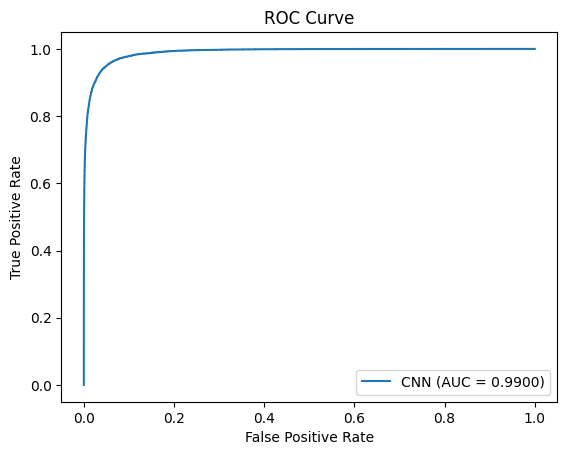

In [ ]:
# Train & Evaluate CNN
cnn_model = create_cnn()
print("\nTraining CNN Model...")
train_and_evaluate(cnn_model, "CNN")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training MLP Model...
Epoch 1/20
782/782 - 10s - 13ms/step - accuracy: 0.2553 - loss: 2.0161 - val_accuracy: 0.3398 - val_loss: 1.8331 - learning_rate: 1.0000e-03
Epoch 2/20
782/782 - 3s - 4ms/step - accuracy: 0.3141 - loss: 1.8661 - val_accuracy: 0.3547 - val_loss: 1.7882 - learning_rate: 1.0000e-03
Epoch 3/20
782/782 - 3s - 4ms/step - accuracy: 0.3376 - loss: 1.8161 - val_accuracy: 0.3767 - val_loss: 1.7095 - learning_rate: 1.0000e-03
Epoch 4/20
782/782 - 3s - 3ms/step - accuracy: 0.3543 - loss: 1.7744 - val_accuracy: 0.4074 - val_loss: 1.6817 - learning_rate: 1.0000e-03
Epoch 5/20
782/782 - 5s - 7ms/step - accuracy: 0.3644 - loss: 1.7512 - val_accuracy: 0.3942 - val_loss: 1.6913 - learning_rate: 1.0000e-03
Epoch 6/20
782/782 - 5s - 6ms/step - accuracy: 0.3725 - loss: 1.7341 - val_accuracy: 0.4109 - val_loss: 1.6646 - learning_rate: 1.0000e-03
Epoch 7/20
782/782 - 3s - 4ms/step - accuracy: 0.3785 - loss: 1.7115 - val_accuracy: 0.4196 - val_loss: 1.6286 - learning_rate: 1.0000e-03
Ep

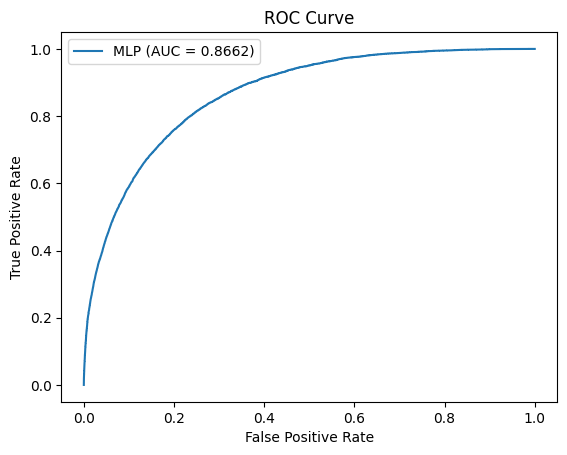

In [ ]:
# Train & Evaluate MLP
mlp_model = create_mlp()
print("\nTraining MLP Model...")
train_and_evaluate(mlp_model, "MLP")

#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.